<a href="https://colab.research.google.com/github/korkutanapa/SUDE_TUBA_FORECASTING/blob/main/a6ac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-8rcex4nv
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-8rcex4nv
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 94e20ea7e510ac4d665492b8bed8836a5143f16e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch  # PyTorch to convert values into torch tensors.

In [48]:
from chronos import ChronosPipeline

In [49]:
'''initialize CHRONOS pipeline'''
pipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-tiny",
                                            device_map = "auto",
                                            torch_dtype = torch.bfloat16)

In [55]:
# Read the CSV file in the directory
csv_file_path = "/content/Filled_Production_Data2.xlsx" # Replace with the actual path to your CSV file
series= pd.read_excel(csv_file_path)

In [56]:
series

,Operation
0,108419
1,70326
2,71441
3,76979
4,76923
5,101673
6,81612
7,99590
8,72525
9,90949


In [57]:
train = series.head(44) # train data
test = series.tail(4) # test data

In [58]:
train

,Operation
0,108419
1,70326
2,71441
3,76979
4,76923
5,101673
6,81612
7,99590
8,72525
9,90949


In [67]:
test

,Operation
44,59458
45,56882
46,52676
47,39679


In [68]:
to_predict = torch.tensor(train['Operation'])# variable for training and predict
horizon = 4 # forecasting steps

In [69]:
forecast = pipeline.predict(to_predict, horizon)

In [70]:
up, median, low = np.quantile(forecast[0].numpy(),[0.1,0.5,0.9], axis = 0)

In [71]:
median

array([53561.26367188, 48805.82226562, 50557.82617188, 51308.68554688])

In [72]:
from sklearn.metrics import mean_absolute_error

# Select the 'Operation' column from the 'test' DataFrame
mae = mean_absolute_error(test['Operation'], median)

mae

6930.193359375

In [73]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate the mean absolute percentage error between the median forecast and the test data
mape = mean_absolute_percentage_error(test['Operation'], median)
mape

0.1436154142248568

TIMESFM

In [74]:
pip install utils

In [75]:
pip install timesfm

In [76]:
pip install jax

In [77]:
import pandas as pd
import numpy as np
import utils
import timesfm

In [78]:
import warnings
warnings.filterwarnings("ignore")

In [79]:
# For Torch
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=32,
          horizon_len=4,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-1.0-200m-pytorch"),
  )

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

In [80]:
# Create a 'ds' column with hour values from 0 to 679
train['ds'] = range(44)

# Optionally, reorder columns so 'ds' is the first column
train = train[['ds', 'Operation']]

# Rename the 'Operation' column to 'y'
train.rename(columns={'Operation': 'y'}, inplace=True)

In [81]:
train['unique_id'] = ['T1'] * len(train)

print(train.head())

   ds       y unique_id
0   0  108419        T1
1   1   70326        T1
2   2   71441        T1
3   3   76979        T1
4   4   76923        T1


In [82]:
# Ensure that the 'ds' column in the 'train' DataFrame is of datetime type
train['ds'] = pd.to_datetime(train['ds'])

forecast_df = tfm.forecast_on_df(
    inputs=train,
    freq="H",
    value_name="y",
    num_jobs=-1,
)

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


In [83]:
forecast_df

,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,T1,1970-01-01 01:00:00.000000043,51650.289062,41512.777344,44516.058594,46975.578125,49333.417969,51650.289062,54454.906250,57257.746094,61169.894531,67460.609375
1,T1,1970-01-01 02:00:00.000000043,52201.484375,41759.972656,44806.179688,47308.109375,49458.710938,52201.484375,54996.984375,57585.093750,61695.117188,68416.039062
2,T1,1970-01-01 03:00:00.000000043,52472.757812,41598.449219,44712.007812,47170.468750,49843.902344,52472.757812,54861.597656,58308.109375,62374.574219,69419.304688
3,T1,1970-01-01 04:00:00.000000043,54179.480469,42548.500000,46190.953125,48684.699219,51702.835938,54179.480469,57278.789062,60754.593750,65412.609375,72716.070312


In [87]:
forecast_df['timesfm-q-0.6']

,timesfm-q-0.6
0,54454.906250
1,54996.984375
2,54861.597656
3,57278.789062


In [94]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
# Ensure the test DataFrame has the same datetime index as forecast_df
test
median = forecast_df['timesfm-q-0.5']

# Calculate the mean absolute error between the median forecast and the test data
mae = mean_absolute_error(test['Operation'], median)
mae

# Calculate MAPE
mape = mean_absolute_percentage_error(test['Operation'], median)

mape

0.14572560787200928

In [95]:
mae

6797.9873046875

LAGLLAMA

In [96]:
!git clone -b update-gluonts https://github.com/time-series-foundation-models/lag-llama/

fatal: destination path 'lag-llama' already exists and is not an empty directory.


In [97]:
import os

# Check if the directory exists before changing the current working directory
directory = 'lag-llama'
if os.path.exists(directory):
    os.chdir(directory)
else:
    print(f"Directory '{directory}' does not exist.")

In [98]:
!pip install -U -r requirements.txt  # this could take some time # ignore the errors displayed by colab

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [99]:
!pip install -U -r requirements.txt  # this could take some time # ignore the errors displayed by colab

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [100]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir lag-llama

lag-llama/lag-llama.ckpt


In [101]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator

import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

In [102]:
import sys
from types import ModuleType

# Create dummy module hierarchy
def create_dummy_module(module_path):
    """
    Create a dummy module hierarchy for the given path.
    Returns the leaf module.
    """
    parts = module_path.split('.')
    current = ''
    parent = None

    for part in parts:
        current = current + '.' + part if current else part
        if current not in sys.modules:
            module = ModuleType(current)
            sys.modules[current] = module
            if parent:
                setattr(sys.modules[parent], part, module)
        parent = current

    return sys.modules[module_path]

# Create the dummy gluonts module hierarchy
gluonts_module = create_dummy_module('gluonts.torch.modules.loss')

# Create dummy classes for the specific loss functions
class DistributionLoss:
    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        return 0.0

    def __getattr__(self, name):
        return lambda *args, **kwargs: None

class NegativeLogLikelihood:
    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        return 0.0

    def __getattr__(self, name):
        return lambda *args, **kwargs: None

# Add the specific classes to the module
gluonts_module.DistributionLoss = DistributionLoss
gluonts_module.NegativeLogLikelihood = NegativeLogLikelihood

In [103]:
import torch

def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):
    # Explicitly allowlist the 'StudentTOutput' class as a safe global
    from gluonts.torch.distributions.studentT import StudentTOutput  # Import the class
    torch.serialization.add_safe_globals([StudentTOutput])

    # Now load the checkpoint with weights_only=False or add it to safe globals
    ckpt = torch.load("lag-llama/lag-llama.ckpt", map_location=torch.device('cpu'),
                      weights_only=False)  # or add to safe globals before
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
    # ... (rest of your function remains the same)

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [104]:
import pandas as pd

# Assume 'train' is already defined and has columns 'ds', 'y', and 'unique_id'
n_rows = len(train)

# Create an hourly datetime index starting from a chosen start date (adjust as needed)
hourly_index = pd.date_range(start='2020-01-01 00:00:00', periods=n_rows, freq='H')

# Create the new dataframe with the desired structure
df = pd.DataFrame({
    'target': train['y'].values,
    'item_id': train['unique_id'].values
}, index=hourly_index)

# Optional: display the first few rows of the new dataframe
print(df.tail())

                     target item_id
2020-01-02 15:00:00   40898      T1
2020-01-02 16:00:00   59000      T1
2020-01-02 17:00:00   45350      T1
2020-01-02 18:00:00   55309      T1
2020-01-02 19:00:00   43941      T1


In [105]:
from gluonts.dataset.pandas import PandasDataset

In [106]:
# Set numerical columns as float32
for col in df.columns:
    # Check if column is not of string type
    if df[col].dtype != 'object' and pd.api.types.is_string_dtype(df[col]) == False:
        df[col] = df[col].astype('float32')

# Create the Pandas
dataset = PandasDataset.from_long_dataframe(df, target="target", item_id="item_id")

backtest_dataset = dataset
prediction_length = 4  # Define your prediction length. We use 24 here since the data is of hourly frequency
num_samples = 100 # number of samples sampled from the probability distribution for each timestep
device = torch.device("cpu") # You can switch this to CPU or other GPUs if you'd like, depending on your environment

In [107]:
# Updated function call to handle CPU-only environment
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, device, num_samples)

In [108]:
len(forecasts)

1

In [109]:
forecasts[0].samples.shape

(100, 4)

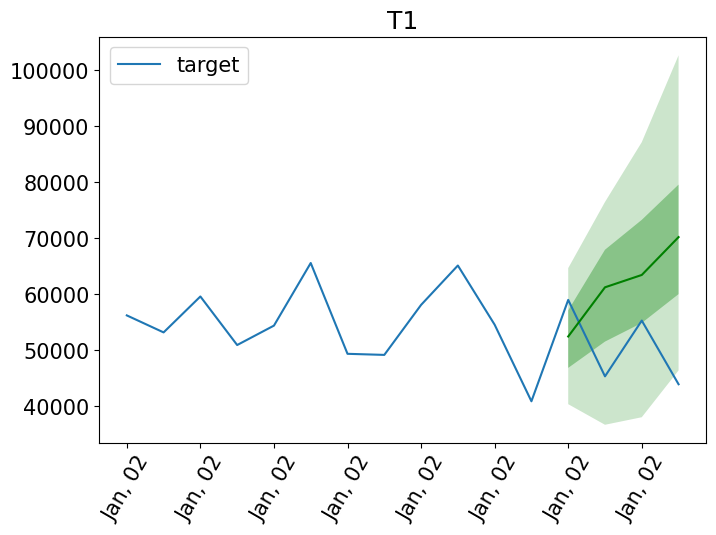

In [110]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [111]:
y_pred=forecasts[0].mean

In [112]:
mae = mean_absolute_error(test['Operation'], y_pred)
mae

13270.0

In [113]:
mape = mean_absolute_percentage_error(test['Operation'], y_pred)
mape

0.29611775279045105